In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [3]:
path_to_image_buoy1 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy1\\train\\buoy156.png'
path_to_image_buoy2 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy2\\train\\buoy108.png'
path_to_image_buoy3 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy3\\train\\buoy28.png'
img1 = cv2.imread(path_to_image_buoy1)
img2 = cv2.imread(path_to_image_buoy2)
img3 = cv2.imread(path_to_image_buoy3)
cv2.imshow('img1',img1)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

mu:9.765625sigma:19.870275
mu:9.765625sigma:26.297571
mu:9.765625sigma:10.711766


c:\users\shant\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\shant\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


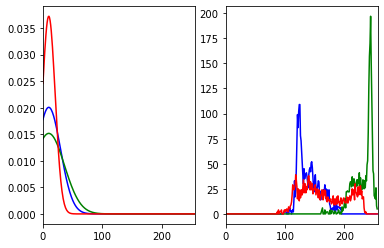

In [4]:
# Compute the average colour histogram for each of the RGB Colour channels
from scipy.stats import norm

def fit_gaussian(image):
    
    color = ('b' , 'g' , 'r') # The number of color channels
    
    for i, col in enumerate(color):
        
        # Calculate the histogram for the Red Green and Blue color channel
        # If input is grayscale the channels = [0] but for color image the channels can be [0], [1], [2]
        histr = cv2.calcHist([image],[i],None,[256],[0,256])

        (mu , sigma) = norm.fit(histr) # Maximum likelihood estimate
        bins = np.linspace(0,255,256)
        print("mu:" + str(mu) + "sigma:" + str(sigma))
        plt.subplot(1,2,1)
        plt.plot(bins, norm.pdf(bins,mu,(sigma)),color=col); plt.xlim([0,256])
        plt.subplot(1,2,2)
        plt.plot(histr,color = col); plt.xlim([0,256])
    plt.show()
    
fit_gaussian(img3)

In [139]:
# initialise step of em algorithm
def initialise_step(n, d, k):
    """
    Inputs:
    n - number of data-points
    d - dimension of the gaussian
    k - number of the gaussians
    
    Outputs:
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    probability_values - probability of the datapoint being in the k-gaussians, size (n x k)
    """
    
    weights_gaussian = np.zeros(k)
    mean_gaussian = np.zeros((k, d))
    covariance_matrix_gaussian = np.zeros((k, d, d))
    probability_values = np.zeros((n, k))
    
    # randomly assign probability values
    for index in range(0, n):
        probability_values[index][np.random.randint(0, k)] = 1
        
    # return the arrays
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)


# gaussian estimation for expectation step
def gaussian_estimation(data_point, mean, covariance, dimension):
    """
    Inputs:
    data_point - data point of the gaussian, size (1 x d)
    mean - mean of the gaussian, size (1 x d)
    covariance - covariance of the gaussian, size (1 x d x d)
    dimension - dimension of the gaussian
    
    Outputs:
    value of the gaussian
    """
    
    determinant_covariance = np.linalg.det(covariance)
    determinant_covariance_root = np.sqrt(determinant_covariance)
    covariance_inverse = np.linalg.inv(covariance)
    gaussian_pi_coeff = 1.0 / np.power((2 * np.pi), (dimension / 2))
    data_mean_diff = (data_point - mean)
    data_mean_diff_transpose = data_mean_diff.T     
    return (gaussian_pi_coeff) * (determinant_covariance_root) * np.exp(-0.5 * np.matmul(np.matmul(data_mean_diff, covariance_inverse), data_mean_diff_transpose))


# e-step of the algorithm
# reference: https://towardsdatascience.com/an-intuitive-guide-to-expected-maximation-em-algorithm-e1eb93648ce9
def expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values):
    """
    Inputs:
    n - the number of data-points
    d - dimension of gaussian
    k - number of gaussians
    data - data to be trained on of size (n x d)
    weights_gaussian - weight of gaussians of size (k)
    mean_gaussian - mean of gaussians of size (k x d)
    covariance_matrix_gaussian - covariance of gaussians of size (k x d x d)
    probability_values - probability of the datapoint being in a gaussian of size (n x k)
    
    Outputs:
    probabilities - probability array of size (n x k)
    """
    
    # create empty array of list of probabilities
    probabilities = []
    
    # iterate through each item
    for j in range(0, n):
        
        # calculate probability of a point being in the k-gaussians
        probability_x = 0.0
        for i in range(0, k):
            probability_x = probability_x + gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i], d) * weights_gaussian[i]
        probability_x_temp = []    
        for i in range(0, k):
            val = (gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i], d) * weights_gaussian[i]) / probability_x
            probability_x_temp.append(val)
        
        # append probabilities of a point being in k-gaussians of size (1 x k)
        probabilities.append(probability_x_temp)
    return np.array(probabilities)


# update weights, maximization step
def update_weights(probabilities, k):
    """
    Inputs:
    k - number of gaussians
    probability - probability of the datapoint being in the k-gaussians, size (n x k)
    
    Outputs:
    updated_weights - weights of the k-gaussians, size (k)
    """
    
    probabilities = np.array(probabilities)
    updated_weights = []
    for i in range(0, k):
        updated_weights.append(np.sum(probabilities[:, i]))
    updated_weights = np.array(updated_weights)
    return updated_weights / np.sum(updated_weights)


# update mean, maximization step
def update_mean(data, probabilities, k):
    """
    Inputs:
    data - training data, size (n x d)
    probability - probability of the datapoints being in k-gaussians, size (n x k)
    k - number of the gaussians
    
    Outputs:
    updated_mean - mean of the k-gaussians, size (k x d)
    """
    
    probabilities = np.array(probabilities)
    data = np.array(data)
    updated_weights = []
    updated_mean = np.matmul(probabilities.T, data)
    for i in range(0, k):
        updated_weights.append(np.sum(probabilities[:, i]))
        updated_mean[i] = updated_mean[i] / updated_weights[i]
    return updated_mean


# update covariance, maximization step
def update_covariance(data, probabilities_values, mean_gaussian, k, d, n):
    """
    Inputs:
    data - data to be trained on of size (n x d)
    probability_values - probability of the datapoint being in k-gaussians, size (n x k)
    mean_gaussian - mean of the k-gaussians, size (k x d)
    k - number of gaussians
    d - dimension of the gaussian
    n - number of data-points
    
    Outputs:
    probabilities - probability array, size (n x k)
    """
    
    probabilities_values = np.array(probabilities_values)
    mean_gaussian = np.array(mean_gaussian)
    data = np.array(data)
    probabilities_sum = []
    k_array = []
    for i in range(0, k):
        probabilities_sum.append(np.sum(probabilities_values[:, i]))
        covariance_array = []
        for index1 in range(0, d):
            temp_array = []
            for index2 in range(0, d):
                check = 0
                for index3 in range(0, n):
                    check = check + (probabilities_values[index3, i] * (data[index3, index1] - mean_gaussian[i, index1]) * (data[index3, index2] - mean_gaussian[i, index2]))
                check = check / probabilities_sum[i]
                if(index1 == index2):
                    if(np.abs(check) < 0.0001):
                        check = 0.0001
                temp_array.append(check)
            covariance_array.append(temp_array)
        k_array.append(covariance_array)
    return k_array


# m-step of the algorithm
# reference: https://towardsdatascience.com/an-intuitive-guide-to-expected-maximation-em-algorithm-e1eb93648ce9
def maximization_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values):
    """
    Inputs:
    n - number of data-points
    d - dimension of gaussian
    k - number of gaussians
    data - training data, size (n x d)
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    probability_values - probability of the datapoint being in a gaussian, size (n x k)
    
    Outputs:
    u_weights - weight of the gaussians, size (k)
    u_mean_gaussian - mean of the gaussians, size (k x d)
    u_covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    """
    
    u_weights = update_weights(probability_values, k)
    u_mean_gaussian = update_mean(data, probability_values, k)
    u_covariance_matrix_gaussian = update_covariance(data, probability_values, mean_gaussian, k, d, n)
    return (u_weights, u_mean_gaussian, u_covariance_matrix_gaussian)

# run e-m algorithm
def run_expectation_maximization_algorithm(n, d, k, iterations, data):
    """
    Inputs:
    n - number of data-points
    d - dimension of gaussian
    k - number of gaussians
    iterations - number of iterations 
    data - training data, size (n x d)
    
    Outputs:
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    """
    
    # initialise step
    (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values) = initialise_step(n, d, k)
    
    # run for fixed iterations
    for i in range(0, iterations):
    
        # m-step
        (weights_gaussian, mean_gaussian, covariance_matrix_gaussian) = maximization_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)
    
        # e-step
        probability_values = expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)
    
    # return answer
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian)

# plot histogram
def plot_hist(image):
    # loop over the image channels
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    features = []
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        features.extend(hist)
        plt.plot(hist, color = color)
        plt.xlim([0, 256])

In [140]:
data = []
for row in range(img2.shape[0]):
    for col in range(img2.shape[1]):
        val = []
        val.append(img2[row, col, 2])
        data.append(val)

In [141]:
data = np.array(data)
print(data.shape)

(2500, 1)


In [142]:
(weights_gaussian, mean_gaussian, covariance_matrix_gaussian) = run_expectation_maximization_algorithm(2500, 1, 2, 50, data)

In [143]:
print(weights_gaussian)

[1.00000000e+000 1.61951165e-110]


In [144]:
print(mean_gaussian)

[[245.]
 [255.]]


In [146]:
print(covariance_matrix_gaussian)

[[[238.4696]], [[0.0001]]]


In [12]:
y = []
x = []
for i in range(0, 256):
    x.append(i)
    output = gaussian_estimation(i, mean_gaussian[0], covariance_matrix_gaussian[0], 1) * weights_gaussian[0]
    y.append(output)

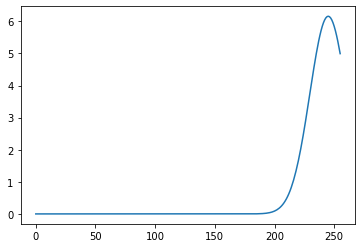

In [13]:
plt.plot(x, y)
plt.show()

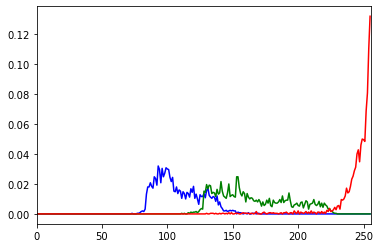

In [14]:
plot_hist(img2)

In [132]:
# Compute the average colour histogram for each of the RGB Colour channels
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
%matplotlib inline

path_to_image_buoy1 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy1\\train\\buoy156.png'
path_to_image_buoy2 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy2\\train\\buoy108.png'
path_to_image_buoy3 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy3\\train\\buoy28.png'
img1 = cv2.imread(path_to_image_buoy1)
img2 = cv2.imread(path_to_image_buoy2)
img3 = cv2.imread(path_to_image_buoy3)
cv2.imshow('img1',img1)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [123]:
# initialise step of em algorithm
def initialise_step(n, d, k):
    """
    Inputs:
    n - number of data-points
    d - dimension of the gaussian
    k - number of the gaussians
    
    Outputs:
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    probability_values - probability of the datapoint being in the k-gaussians, size (n x k)
    """
    
    weights_gaussian = np.zeros(k)
    mean_gaussian = np.zeros((k, d))
    covariance_matrix_gaussian = np.zeros((k, d, d))
    probability_values = np.zeros((n, k))
    
    # randomly assign probability values
    for index in range(0, n):
        probability_values[index][np.random.randint(0, k)] = 1
        
    # return the arrays
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)

# Fit a gaussian using the datapoints obtained using the histogram
def fit_gaussian(image):
    
    color = ('b' , 'g' , 'r') # The number of color channels
    
    for i, col in enumerate(color):
        
        # Calculate the histogram for the Red Green and Blue color channel
        # If input is grayscale the channels = [0] but for color image the channels can be [0], [1], [2]
        histr = cv2.calcHist([image],[i],None,[256],[0,256])

        (mu , sigma) = norm.fit(histr) # Maximum likelihood estimate
        bins = np.linspace(0,255,256)
        print("mu:" + str(mu) + "sigma:" + str(sigma))
        plt.subplot(1,2,1)
        plt.plot(bins, norm.pdf(bins,mu,(sigma)),color=col); plt.xlim([0,256])
        plt.subplot(1,2,2)
        plt.plot(histr,color = col); plt.xlim([0,256])
    plt.show()

# gaussian estimation for expectation step
def gaussian_estimation(data_point, mean, covariance, dimension):
    """
    Inputs:
    data_point - data point of the gaussian, size (1 x d)
    mean - mean of the gaussian, size (1 x d)
    covariance - covariance of the gaussian, size (1 x d x d)
    dimension - dimension of the gaussian
    
    Outputs:
    value of the gaussian
    """
    
    determinant_covariance = np.linalg.det(covariance)
    determinant_covariance_root = np.sqrt(determinant_covariance)
    covariance_inverse = np.linalg.inv(covariance)
    gaussian_pi_coeff = 1.0 / np.power((2 * np.pi), (dimension / 2))
    data_mean_diff = (data_point - mean)
    data_mean_diff_transpose = data_mean_diff.T     
    return (gaussian_pi_coeff) * (determinant_covariance_root) * np.exp(-0.5 * np.matmul(np.matmul(data_mean_diff, covariance_inverse), data_mean_diff_transpose))

# Perform the expectation step
def expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values):
    """
    Inputs:
    n - the number of data-points
    d - dimension of gaussian
    k - number of gaussians
    data - data to be trained on of size (n x d)
    weights_gaussian - weight of gaussians of size (k)
    mean_gaussian - mean of gaussians of size (k x d)
    covariance_matrix_gaussian - covariance of gaussians of size (k x d x d)
    probability_values - probability of the datapoint being in a gaussian of size (n x k)
    
    Outputs:
    probabilities - probability array of size (n x k)
    """
    
    # create empty array of list of probabilities
    probabilities = []
    
    # iterate through each item
    for j in range(0, n):
        
        # calculate probability of a point being in the k-gaussians
        probability_x = 0.0
        for i in range(0, k):
            probability_x = probability_x + gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i], d) * weights_gaussian[i]
        probability_x_temp = []    
        for i in range(0, k):
            val = (gaussian_estimation(data[j], mean_gaussian[i], covariance_matrix_gaussian[i], d) * weights_gaussian[i]) / probability_x
            probability_x_temp.append(val)
        
        # append probabilities of a point being in k-gaussians of size (1 x k)
        probabilities.append(probability_x_temp)
    return np.array(probabilities)


# The maximization step will compute the mean, the mixture prior and the Covariance for each of the gaussian"
def maximization_gaussian(self, data_probabilities, input_data):
    
    "K: Number of components of the gaussian mixture"
    "input_data: (NxD) which is number of datapoints times the dimension of each data point"
    "phi_k: List of mixture coefficients of size K"
    "mean_k: List of mean for the kth component of the Gaussian Mixture of the size (Kxd)"
    "sigma_square_k: Variance of the kth component of the mixture model (Kxdxd)"
    "data_probabilities: Probability of the ith datapoint coming from gaussian k. The size of this matrix is (nxk)"
    
    # Number if Gaussians
    K = self.data_probabilities.shape[1]
    
    # Calculation for mixture model coefficients phi_k"
    self.phi_k = np.mean(data_probabilities, axis = 0)
    
    # Calculation of the mean for each k gaussian
    self.mean_k = np.matmul(data_probabilities.T, input_data) / np.sum(data_probabilities, axis = 0)[:,np.newaxis]
    
    #Calculation of the Variance for each kth Gaussian Distribution
    
    # Loop over each Gaussian
    for k in range(K):
        
        # Compute the difference of the ith data point with the kth gaussian mean
        x = input_data - self.mean_k[k,:]
        
        # Compute the transpose
        x_transpose = x.T
        
        # Convert the kth column of the probability matrix into a sparse diagonal matrix
        probability_diag = np.diag(data_probabilities[:,k])
        covariance_numerator = np.matmul(np.matmul(probability_diag, x) , x_transpose)
        
        # The covariance numerator is again a diagonal matrix whose elements we need to sum
        # k = 0 signifies take the main diagonal
        covariance_numerator = np.sum(np.diag(covariance_numerator,k=0))
        
        # Compute the covariance
        self.covariance[k,:,:] = covariance_numerator /  np.sum(data_probabilities,axis=0)[:,np.newaxis][k]
    
    return self.phi_k , self.mean_k , self.covariance

# run e-m algorithm
def run_expectation_maximization_algorithm(n, d, k, iterations, data):
    """
    Inputs:
    n - number of data-points
    d - dimension of gaussian
    k - number of gaussians
    iterations - number of iterations 
    data - training data, size (n x d)
    
    Outputs:
    weights_gaussian - weight of the gaussians, size (k)
    mean_gaussian - mean of the gaussians, size (k x d)
    covariance_matrix_gaussian - covariance of the gaussians, size (k x d x d)
    """
    
    # initialise step
    (weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values) = initialise_step(n, d, k)
    
    # run for fixed iterations
    for i in range(0, iterations):
        
        # e-step
        probability_values = expectation_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)
        
        # m-step
        (weights_gaussian, mean_gaussian, covariance_matrix_gaussian) = maximization_step(n, d, k, data, weights_gaussian, mean_gaussian, covariance_matrix_gaussian, probability_values)
    

    
    # return answer
    return (weights_gaussian, mean_gaussian, covariance_matrix_gaussian)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

array([[1, 2],
       [3, 4]])